In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [3]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    print(f'web search results: {results}')
    return {"context": results}

In [ ]:
from langchain_openai import ChatOpenAI

#간단한 추론은 로컬 모델로 구동
basic_llm = ChatOpenAI(
    model="Qwen/Qwen3-4B-Instruct-2507", 
    base_url="http://localhost:8000/v1",
    temperature=0.05, 
)

# basic_llm = ChatOpenAI(
#     model="gpt-4o-mini"
# )

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_prompt = hub.pull("rlm/rag-prompt")
generae_llm = ChatOpenAI(model="gpt-4o")

# 복잡한 추론 + 웹 검색의 결과 컨텍스트가 길어서 상용 모델로 구동
def web_generate(state: AgentState):
    context = state["context"]
    query = state["query"]
    rag_chain = generate_prompt | generae_llm | StrOutputParser()
    response = rag_chain.invoke({"question": query, "context": context})
    return {"answer": response}

In [6]:
def basic_generate(state: AgentState):
    query = state["query"]
    basic_llm_chain = basic_llm | StrOutputParser()
    response = basic_llm_chain.invoke(query)
    return {"answer": response}

In [ ]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

router_system_prompt = """
You are an expert at routing a user's question to 'vector_store', 'llm', or 'web_search'
'vector_store' contains information about income tax.
if you think the question is simple enough, use 'llm'
if you think you need to search the web to answer the question, use 'web_search'
"""

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(description="The target to route the query to answer")

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])

#간단한 추론은 로컬 모델로 구동
router_llm = ChatOpenAI(
    model="Qwen/Qwen3-4B-Instruct-2507", 
    base_url="http://localhost:8000/v1",
    temperature=0.95,
) 

# router_llm = ChatOpenAI(
#     model="gpt-4o-mini"
# )

structured_router_llm = router_llm.with_structured_output(Route)

def router(state: AgentState):
    query = state["query"]
    router_chain = router_prompt | structured_router_llm
    route = router_chain.invoke({"query": query})
    print(f'router routne == {route}')
    return route.target

In [8]:
from income_tax_graph import graph as income_tax_subgraph 

graph_builder.add_node('income_tax_agent', income_tax_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

In [9]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('income_tax_agent', END)
graph_builder.add_edge('basic_generate', END)

In [10]:
graph = graph_builder.compile()

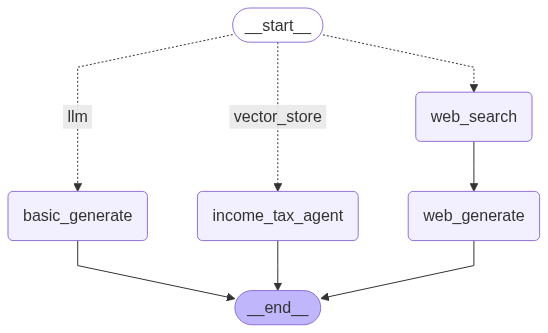

In [11]:
from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
initial_state = {"query": "거주자의 연봉이 5천만원일 때 소득세는 얼마인가요?"}

graph.invoke(initial_state)

router routne == target='vector_store'
context: [Document(id='99158009-6511-47f5-bb6d-083a5f5e65cf', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022

{'query': '거주자의 연봉이 5천만원일 때 소득세는 얼마인가요?',
 'context': [Document(id='99158009-6511-47f5-bb6d-083a5f5e65cf', metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29.